In [7]:
import pymongo as pm #import MongoClient only
import numpy as np
from datetime import datetime, timezone
import matplotlib.pyplot as plt
client = pm.MongoClient('bigdatadb.polito.it',
ssl=True,
authSource = 'carsharing',
username = 'ictts',
password ='Ict4SM22!',
tlsAllowInvalidCertificates=True)
db = client['carsharing'] #Choose the DB to use
Bookings_collection = db['PermanentBookings'] # Collection for Car2go to use

In [ ]:
import pprint # prettyprinting for json objects

pprint.pprint(Bookings_collection.find_one({"city":"Munchen"}))

In [ ]:
#example of how many booking are there
db['PermanentBookings'].count_documents({"city":"Torino"})
n = db["ActiveBookings"].count_documents({"driving.distance":{"$ne":"-1"}})
print(db.ActiveBookings.find_one(
{ "city": "Torino" } ,
{ "init_time": 1, "final_time": 1, "_id": 0}
))

In [ ]:
#question 1
collections = ["ActiveBookings", "ActiveParkings", "PermanentBookings", "PermanentParkings","enjoy_ActiveBookings",
"enjoy_ActiveParkings","enjoy_PermanentBookings","enjoy_PermanentParkings"]
for i in collections:
    collection = db[i]
    num_documents = collection.count_documents({})
    print(f"Documents for {i} is: {num_documents}")

In [ ]:
#question 2 
#collections = ["ActiveBookings", "ActiveParkings", "PermanentBookings", "PermanentParkings"]
for i in collections:
    collection = db[i]
    cities = collection.distinct("city")
    print(f"Cities in '{i}': {cities}")

In [ ]:
#question 3 
all_cities = set()

# Loop through each collection and collect distinct cities
for i in collections:
    cities_in_collection = db[i].distinct("city")
    all_cities.update(cities_in_collection)

# Convert the set to a sorted list if you want to print it neatly
all_cities = sorted(all_cities)
print(f"Cities for which the system is collecting data: {all_cities}")


In [ ]:
#question 4 
for i in collections:
    collection = db[i]
    
    date = [
        {"$group": {
            "_id": None,
            "start_date": {"$min": "$init_date"},
            "end_date": {"$max": "$final_date"}
        }}
    ]
    
    date_dic = list(collection.aggregate(date)) #creaction of list of initial and final date of collection
    
    # Check if result has data
    if date_dic:
        start_date = date_dic[0]["start_date"]
        end_date = date_dic[0]["end_date"]
        print(f"Collection '{i}': Start Date = {start_date}, End Date = {end_date}")
    else:
        print(f"Collection '{i}' has no date data.")

In [ ]:
#question 5
collections = ["ActiveBookings", "ActiveParkings", "PermanentBookings", "PermanentParkings","enjoy_PermanentBookings","enjoy_PermanentParkings"]

for i in collections:
    collection = db[i]
    info = collection.find_one()
    init_date = info.get("init_date")
    timezone = "UTC" if init_date.tzinfo is None else init_date.tzinfo
    print(f"init_date timezone: {timezone}, for collection {i}")

In [ ]:
'''cities Munchen, Washington DC, Catania (Enjoy)
for enjoy collections: "enjoy_ActiveBookings": Contains cars that are currently booked and not available
 "enjoy_ActiveParkings": Contains cars that are currently parked and available
 ”enjoy_PermanentBookings": Contains all booking periods recorded so far
 "enjoy_PermanentParkings": Contains all parking periods recorded so far'''
pprint.pprint(db["enjoy_PermanentBookings"].find_one({"city":"Catania"}))

In [ ]:
#question 1 
from datetime import datetime, timedelta
cities = ["Munchen","Washington DC", "Catania"]

num_cars = {}
city = db["PermanentBookings"].distinct("vin",{"city":"Munchen"})
num_cars["Munchen"]=len(city)
city = db["PermanentBookings"].distinct("vin",{"city":"Washington DC"})
num_cars["Washington DC"]=len(city)
city = db["enjoy_PermanentBookings"].distinct("virtual_rental_id",{"city":"Catania"})
num_cars["Catania"]=len(city)

for city in num_cars:
    print(f"Number of seen cars for {city} --> {num_cars[city]}")

# Define the date range (one week)
start_date_B = datetime(2018, 9, 27, 17, 10, 42)  # Replace with desired start date for Bologna
end_date_B = start_date_B + timedelta(weeks=1)
start_date = datetime(2016, 12, 13, 18, 40, 42)# for Munchen and Washington DC
end_date = start_date + timedelta(weeks=1)

fleet = {}
unique_cars = db["PermanentBookings"].distinct(
        "vin", 
        {"city": "Munchen", "init_date": {"$gte": start_date, "$lt": end_date}}
    )
fleet["Munchen"] = len(unique_cars)
unique_cars = db["PermanentBookings"].distinct(
        "vin", 
        {"city": "Washington DC", "init_date": {"$gte": start_date, "$lt": end_date}}
    )
fleet["Washington DC"] = len(unique_cars)
unique_cars = db["enjoy_PermanentBookings"].distinct(
        "virtual_rental_id", 
        {"city": "Catania", "init_date": {"$gte": start_date_B, "$lt": end_date_B}}
    )
fleet["Catania"] = len(unique_cars)
for city in fleet:
    print(f"fleet size cars for {city} --> {fleet[city]}")


num_cars = {"Munchen": num_cars["Munchen"], "Washington DC": num_cars["Washington DC"], "Catania": num_cars["Catania"]}
fleet = {"Munchen": fleet["Munchen"], "Washington DC": fleet["Washington DC"], "Catania": fleet["Catania"]}

for i in cities:
    total_cars = num_cars[i]  # Total cars over the entire period
    weekly_fleet_size = fleet[i]   # Weekly estimated fleet size
    percentage_active = (weekly_fleet_size / total_cars) * 100 if total_cars > 0 else 0
    print(f"In {i}, approximately {percentage_active:.2f}")

In [ ]:
#question 2


#period
start_date = datetime(2017, 12, 1)
end_date = datetime(2018, 1, 1)

count = 0
bookings_per_city = {}
for i in cities:
    if i == "Catania":
        count = db["enjoy_PermanentBookings"].count_documents({
        "city": i,
        "init_date": {"$gte": start_date, "$lt": end_date}
    })
    else:
        bookings_per_city[i] = count
        count = db["PermanentBookings"].count_documents({
            "city": i,
            "init_date": {"$gte": start_date, "$lt": end_date}
        })
        bookings_per_city[i] = count
    print(f"Number of bookings in December 2017 for {i}: {count}")

In [ ]:
#question 3 
cities = ["Munchen","Washington DC", "Catania"] #for our cities, 0 as public transports is correct because we have info 
                                                # from external sources just for torino and milano
public_transport={}
for i in cities:
    if i == "Catania":
        p_transport = db["enjoy_PermanentBookings"].count_documents({
        "city": i,
        "public_transport.distance": {"$ne": -1}, # {"$ne": -1}: Ensures that the duration is also recorded (not equal to -1).
        "public_transport.duration": {"$ne": -1}
        })
        public_transport[i]=p_transport
    else:
        p_transport = db["enjoy_PermanentBookings"].count_documents({
        "city": i,
        "public_transport.distance": {"$ne": -1},
        "public_transport.duration": {"$ne": -1}
        })
        public_transport[i]=p_transport
    print(f"Number of public transport taken in {i} are: {public_transport[i]}")

In [ ]:
#Step 2
#A  time of November 1st 2017 – January 31st 2018
from datetime import datetime, timedelta
import array
import numpy as np
cities = ["Munchen","Washington DC", "Catania"]

booking = []
parking = []
booking_duration = []
parking_duration = []

start_date = datetime(2017, 11, 1)
end_date = datetime(2018, 1, 31)

for idx,i in enumerate(cities):
    print(i)
    booking_duration.append([])
    parking_duration.append([])
    if i == "Catania":
        for doc in db["enjoy_PermanentBookings"].find({"city": i,
        "init_date": {"$gte": start_date, "$lt": end_date}}):
            booking_duration[idx].append(doc["final_time"]- doc["init_time"])
        
        for doc in db["enjoy_PermanentParkings"].find({"city": i,
        "init_date": {"$gte": start_date, "$lt": end_date}}):
            parking_duration[idx].append(doc["final_time"]- doc["init_time"])
    else:
        for doc in db["PermanentBookings"].find({"city": i,
        "init_date": {"$gte": start_date, "$lt": end_date}}):
            booking_duration[idx].append(doc["final_time"]- doc["init_time"])
        for doc in db["PermanentParkings"].find({"city": i,
        "init_date": {"$gte": start_date, "$lt": end_date}}):
            parking_duration[idx].append(doc["final_time"]- doc["init_time"])




In [ ]:
import seaborn as sns

a = np.array(booking_duration[0])
plt.figure(figsize=(10,6))
sns.histplot(a)
plt.show()

In [ ]:
a = np.array(booking_duration[0])
plt.figure(figsize=(10,6))
sns.histplot(a, bins= 30)
plt.show()

In [ ]:
booking_durations_np = []
filtered_bookings = []
sorted_durations = []
for i in range(3):
    booking_durations_np.append(np.array(booking_duration[i]))
    booking_durations_np[i] = booking_durations_np[i] / 60
    filtered_bookings.append(booking_durations_np[i][(booking_durations_np[i] < 120) & (booking_durations_np[i] > 5)])
    sorted_durations.append(np.sort(filtered_bookings[i]))


plt.figure(figsize=(10,6))
sns.histplot(filtered_bookings)
plt.show()

In [ ]:


n = []
cumulative_probabilities = []
# Step 2: Calculate cumulative probabilities
for i in range(3):
    n.append(len(sorted_durations[i]))
    cumulative_probabilities.append(np.arange(1, n[i] + 1) / n[i])

# Step 3: Plot the empirical CDF
plt.figure(figsize=(8, 5))
for idx, i in enumerate(cities):
    plt.plot(sorted_durations[idx], cumulative_probabilities[idx], label=f"CDF of {i}")


# Labels and Title
plt.xlabel("Booking Duration (minutes)")
plt.ylabel("Cumulative Probability")
plt.title("Empirical CDF of Booking Durations")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
for i in range(3):
    print(len(sorted_durations[i]))

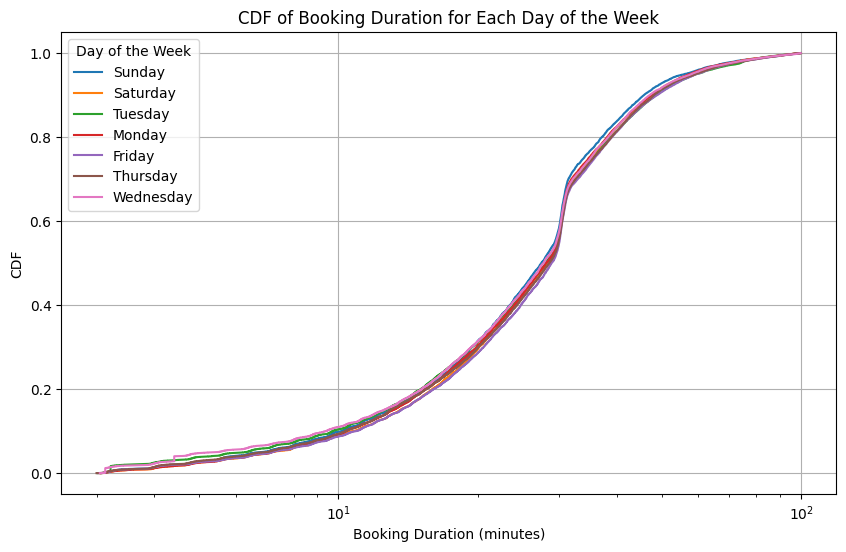

In [52]:

start_date = datetime(2017, 11, 1)
end_date = datetime(2018, 1, 31)
city = "Amsterdam"

pipeline = [
    # Step 1: Calculate the duration in minutes
    {
        "$match": {
            "city": city,
            "init_date": {
                "$gte": start_date,  # Greater than or equal to start_date
                "$lte": end_date  # Less than or equal to end_date
            }
        }
    },
    {
        "$addFields": {
            "duration_minutes": {
                "$divide": [
                    { "$subtract": ["$final_time", "$init_time"] },
                    60  # Convert milliseconds to minutes
                ]
            }
        }
    },
    {
    "$match": {
        "duration_minutes": {
            "$gte": 3,
            "$lte": 100
            }
        }
    },
    # Step 2: Extract day of the week from init_time
    {
        "$addFields": {
            "day_of_week": { "$dayOfWeek": "$init_date" }
        }
    },
    # Step 3: Group by day of the week, accumulating all durations in arrays
    {
        "$group": {
            "_id": "$day_of_week",
            "durations": { "$push": "$duration_minutes" }
        }
    }
]



results = list(db["PermanentBookings"].aggregate(pipeline))


# Map MongoDB day_of_week values to readable day names
day_map = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'}

# Prepare to plot CDF for each day of the week
plt.figure(figsize=(10, 6))

for result in results:
    day_name = day_map[result["_id"]]
    durations = sorted(result["durations"])
    
    # Calculate the CDF values
    cdf_values = np.arange(1, len(durations) + 1) / len(durations)
    
    # Plot the CDF for this day
    plt.plot(durations, cdf_values, label=day_name)

# Set plot labels and legend
plt.xlabel("Booking Duration (minutes)")
plt.ylabel("CDF")
plt.title("CDF of Booking Duration for Each Day of the Week")
plt.legend(title="Day of the Week")
plt.semilogx()
plt.grid(True)
plt.show()

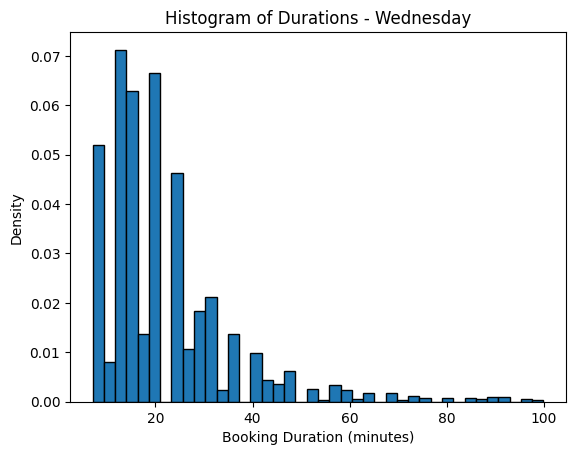

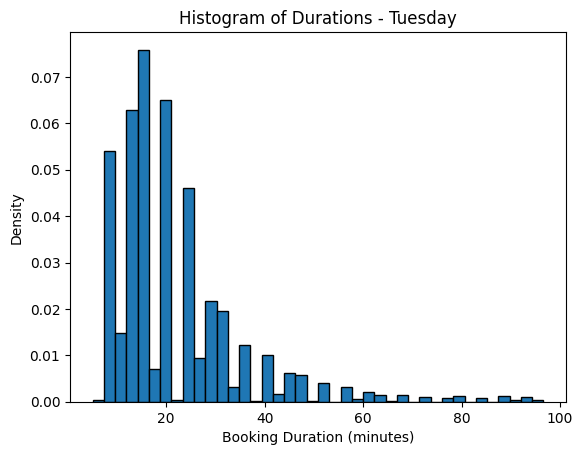

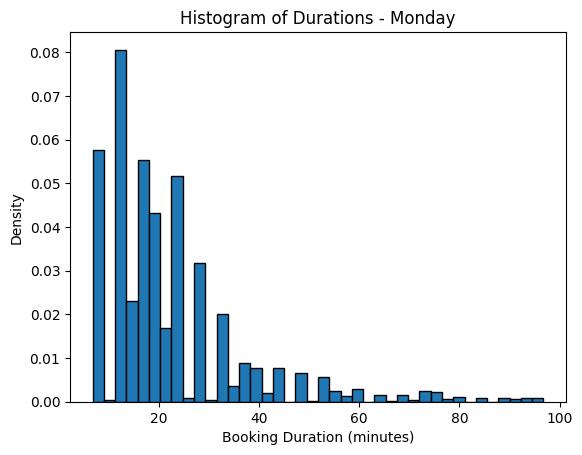

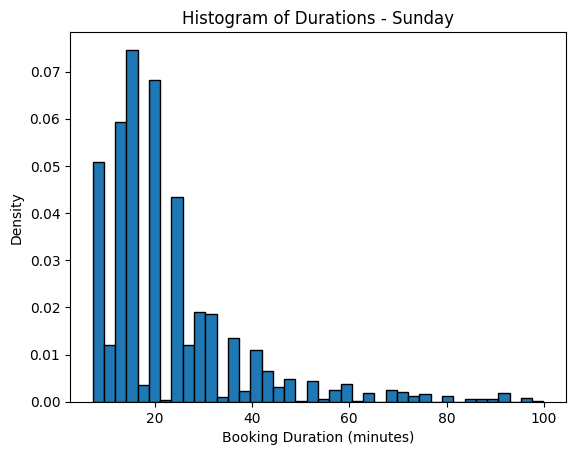

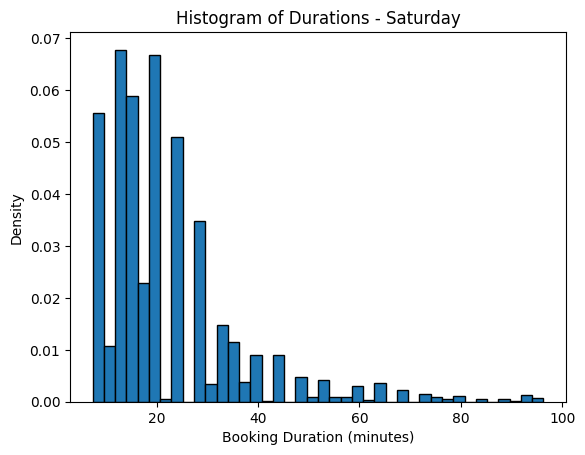

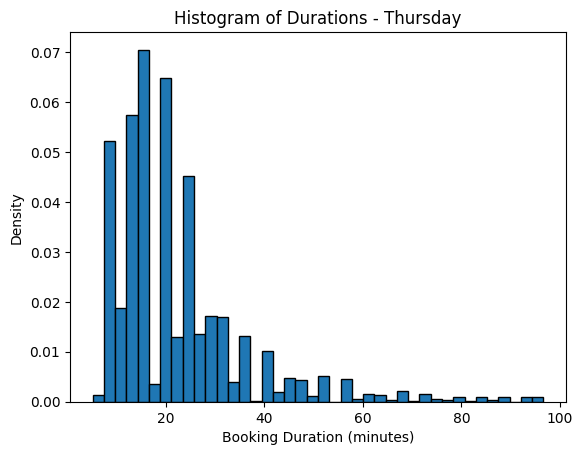

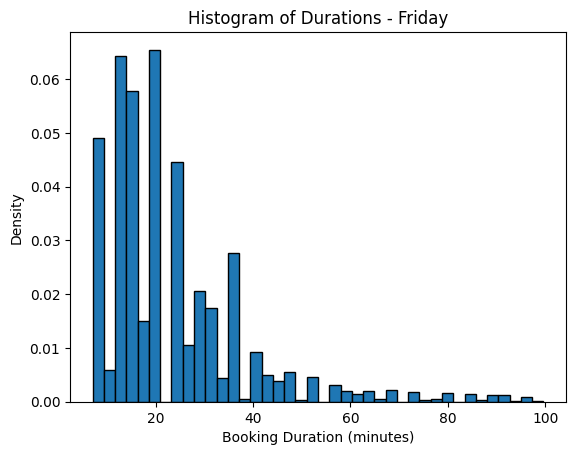

In [24]:
# Number of bins for the histogram
num_bins = 40

# Plot histograms for each day of the week in subplots
for idx, result in enumerate(results):
    day_name = day_map[result["_id"]]
    durations = result["durations"]
    plt.figure()
    # Plot histogram for the current day's data
    plt.hist(durations, bins=num_bins, edgecolor='black', density=True)
    plt.title(f"Histogram of Durations - {day_name}")
    plt.xlabel("Booking Duration (minutes)")
    plt.ylabel("Density")
    plt.show()



# Show the plot


In [27]:
for result in results:
    a = result
    print(np.average(result["durations"]))

22.10229966808914
21.895957645957647
22.4830834047415
23.107282129535434
22.27770695970696
22.335549414824445
23.497315321477426


[11.633333333333333, 44.05, 23.9, 16.216666666666665, 27.966666666666665, 24.05, 16.116666666666667, 15.633333333333333, 20.15, 36.3, 12.45, 16.116666666666667, 12.266666666666667, 7.783333333333333, 7.783333333333333, 12.283333333333333, 20.05, 8.433333333333334, 28.283333333333335, 23.766666666666666, 11.616666666666667, 7.65, 20.55, 15.85, 7.6, 8.35, 20.233333333333334, 23.983333333333334, 16.4, 27.766666666666666, 35.833333333333336, 7.566666666666666, 32.61666666666667, 16.216666666666665, 8.016666666666667, 11.716666666666667, 52.083333333333336, 39.766666666666666, 19.45, 16.533333333333335, 12.183333333333334, 32.45, 72.18333333333334, 15.85, 7.216666666666667, 15.883333333333333, 24.25, 23.533333333333335, 19.883333333333333, 11.816666666666666, 11.766666666666667, 27.983333333333334, 32.43333333333333, 24.316666666666666, 16.333333333333332, 12.45, 11.933333333333334, 72.96666666666667, 8.233333333333333, 31.9, 28.233333333333334, 20.0, 48.333333333333336, 11.883333333333333,

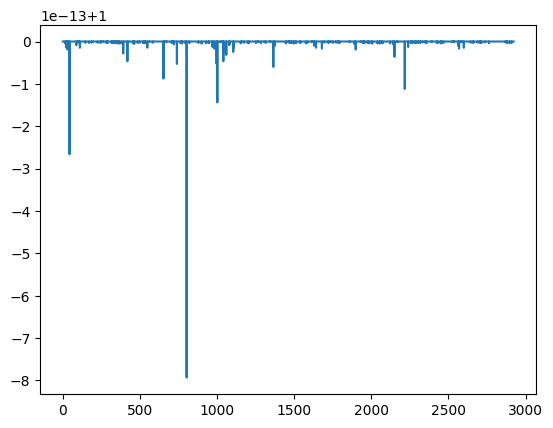

In [33]:
import scipy
import scipy.stats
import seaborn as sns
print(result["durations"])
cdf = scipy.stats.norm.cdf(result["durations"])
plt.plot(cdf)
plt.show()